In [1]:
from textwrap import dedent

def code_hider():
    """Make a button in the jupyter notebook to hide all code"""
    # Stolen from stackoverflow... forget which question
    # I would really like these buttons for every individual cell.. but I don't know how
    from IPython.display import HTML    # Please keep here, don't want hax to depend on ipython!
    return HTML(dedent('''
                       <script>
                       code_show=true
                       function code_toggle() {
                        if (code_show){
                        $('div.input').hide();
                          } else {
                        $('div.input').show();
                        }
                        code_show = !code_show
                       }
                       //$( document ).ready(code_toggle);
                       </script>
                       <form action="javascript:code_toggle()"><input type="submit"
                       value="Show/hide  all code in this notebook"></form>'''))

code_hider()


In [2]:
# Boilerplate startup code
%matplotlib notebook
%matplotlib inline
import math
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import codecs
from datetime import datetime
from scipy.ndimage.filters import gaussian_filter

matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (15.0, 5.0)    # resize plots


def read_file(file):
    COMMENT_CHAR = '#'
    columns = []
    with file as td:
        for line in td:
        
            # find the commented lines
            if line[0] == COMMENT_CHAR or line[0] =='0':
                if ('dure de comptage:') in line:
                    splitvalues= line.split("e:  ")
                    date_str= splitvalues[1][0:-2]
                    
                    time= datetime.strptime(date_str, '%H:%M:%S')- datetime.strptime("1900:1:1",'%Y:%m:%d')
            # when we seethe first line that doesn't start with 
            # COMMENT_CHAR, we pass the remaining lines of the 
            # file to pandas.read_table and break our loop
            else:
                _dfs = [
                        pd.DataFrame([line.split()],  dtype=int),
                        pd.read_table(td, sep='\s+', names=['channel', 'N'], header=None, engine='python')
                        ]
                df = pd.concat(_dfs, ignore_index=True)
    df['NEr'] = [math.sqrt(y)/time.seconds for y in df.N]

    df.N = df.N/time.seconds
    df = df.dropna(thresh=2)
    return df

cs_lines = [661] #keV
co_lines = [1173, 1332]
na_lines = [511, 1274]

/data/anaconda3/lib/python3.5/site-packages/pandas/core/indexes/range.py:453: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  return self._int64index.union(other)


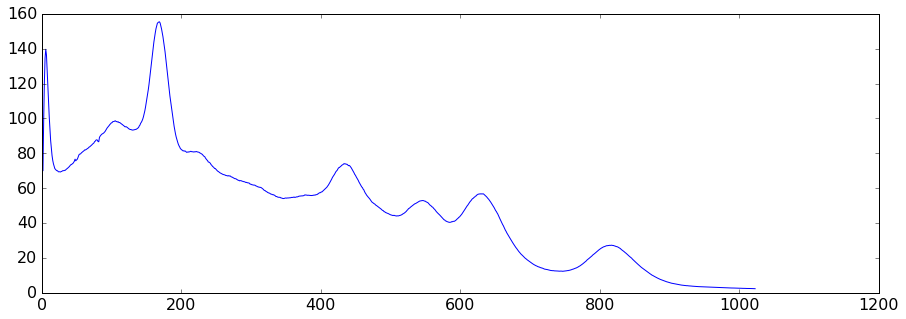

In [20]:
fileEu = codecs.open('data/EU152_03.A01', encoding = "ISO-8859-1")
data = read_file(fileEu)
plt.plot(data.channel, data.N, label="EU 152")




[5, 102, 167, 312, 436, 546, 631, 816, 1017] 5          6.0
102      103.0
167      168.0
312      313.0
436      437.0
546      547.0
631      632.0
816      817.0
1017    1018.0
Name: channel, dtype: float64


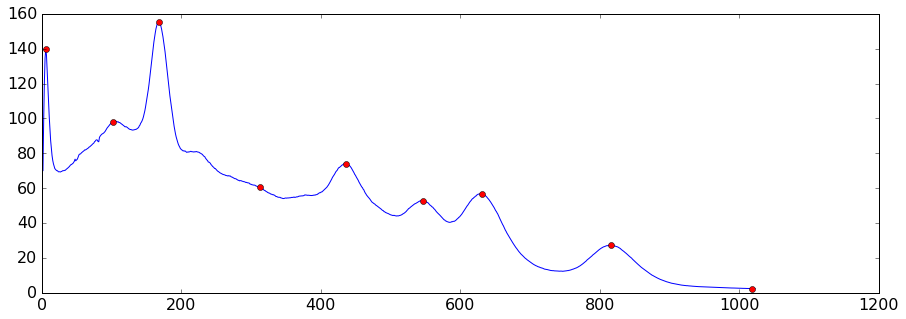

In [93]:
#from scipy.misc import electrocardiogram
import scipy
from scipy import signal

xs = np.arange(0, 3*np.pi, 0.05)
#data = np.sin(xs)
#print(data)
widths = np.arange(5, 100)
data.dropna(subset=['channel'], inplace=True)

peakind = signal.find_peaks_cwt(data.N, widths)
#print(data)
params = [ 4.48558099,  0.50569836]

print(peakind, data.channel[peakind])


#scipy.signal.find_peaks(x, heght = 0)
#from scipy.signal import find_peaks
#x = electrocardiogram()[2000:4000]
#peaks, _ = find_peaks(x, height=0)

plt.plot(data.channel, data.N)
plt.plot(data.channel[peakind], data.N[peakind], color="red", linewidth=0, marker='o')
#plt.plot(peaks, x[peaks], "x")

#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.show()

8        9.0
167    168.0
434    435.0
545    546.0
630    631.0
814    815.0
Name: channel, dtype: float64
[122, 344, 779, 964, 1112, 1408]


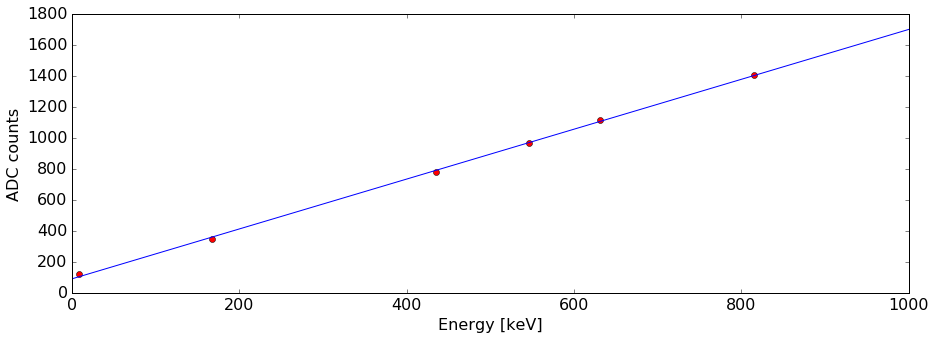

In [92]:
energyEu = [122, 245, 344, 779, 964, 1112, 1408]
peaks_in_data = data.channel[peakind]
values_at_peaks = data.N[peakind]
#peaks_in_data = peaks_in_data.loc[peaks_in_data>10]
peaks_in_data = peaks_in_data.loc[peaks_in_data<1000]

energyEu = [122, 344, 779, 964, 1112, 1408]

print(peaks_in_data)
print(energyEu)
plt.plot(peaks_in_data, energyEu, color="red", linewidth=0, marker='o')

import math
def gaus(x,a,x0,sigma):
    if sigma<0 :
        return -100000
    return a*exp(-(x-x0)**2/(2*sigma**2))

def line(x, a, b):
    return a+b*x
params, cov= curve_fit(line,  peaks_in_data, energyEu, sigma=2)

x = np.linspace(0, 1000, 200)
plt.plot(x, line(x,params[0], params[1]))
plt.ylabel("ADC counts")
plt.xlabel("Energy [keV]")


In [ ]:

df_br = read_file(fileBr)                
plt.errorbar(df_br.channel, df_br.N, yerr=df_br.NEr, label="Bruit")
plt.ylim(0, 0.05)

/data/anaconda3/lib/python3.5/site-packages/pandas/core/indexes/range.py:453: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  return self._int64index.union(other)


/data/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


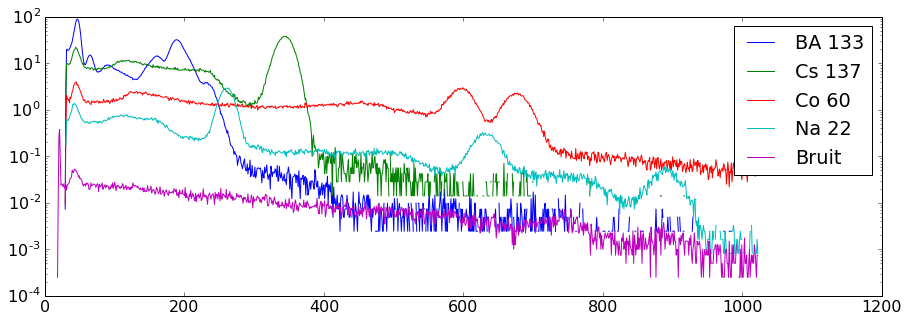

In [50]:
fileBa = codecs.open('data/BA133.A01', encoding = "ISO-8859-1")
fileCs = codecs.open('data/CS137.A01', encoding = "ISO-8859-1")
fileCo = codecs.open('data/CO60.A01', encoding = "ISO-8859-1")
fileNa = codecs.open('data/NA22.A01', encoding = "ISO-8859-1")

df_ba = read_file(fileBa)                
plt.semilogy(df_ba.channel, df_ba.N, label="BA 133")
df_cs = read_file(fileCs)                
plt.semilogy(df_cs.channel, df_cs.N, label="Cs 137")
df_co = read_file(fileCo)                
plt.semilogy(df_co.channel, df_co.N, label="Co 60")
df_na = read_file(fileNa)                
plt.semilogy(df_na.channel, df_na.N, label="Na 22")

fileBr = codecs.open('data/BRUIT.A01', encoding = "ISO-8859-1")

df_br = read_file(fileBr)                
plt.semilogy(df_br.channel, df_br.N, label="Bruit")
plt.legend()


#plt.show()

{'sigma': 12.169371256453374, 'mean': 343.56510183212293, 'sigma_er': 0.03909913090470202, 'mean_er': 0.04888712413733767, 'energy': 661}
{'sigma': 19.50503978102552, 'mean': 595.63329453615222, 'sigma_er': 0.14910143116497288, 'mean_er': 0.12745235458438134, 'energy': 1173}
{'sigma': 18.461701409221664, 'mean': 675.45650947421541, 'sigma_er': 0.2408293171054973, 'mean_er': 0.16705083269354526, 'energy': 1332}
{'sigma': 10.501103128939393, 'mean': 260.45416560879232, 'sigma_er': 0.05541489255217905, 'mean_er': 0.04868103531387872, 'energy': 511}
{'sigma': 19.28187415729646, 'mean': 631.66780233373174, 'sigma_er': 0.25887070997343103, 'mean_er': 0.20803890092140462, 'energy': 1274}
{'sigma': 6.2336356730295508, 'mean': 42.74840287598068, 'sigma_er': 0.132490014148686, 'mean_er': 0.07709071223437464, 'energy': 80}


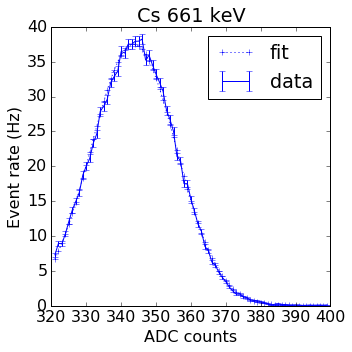

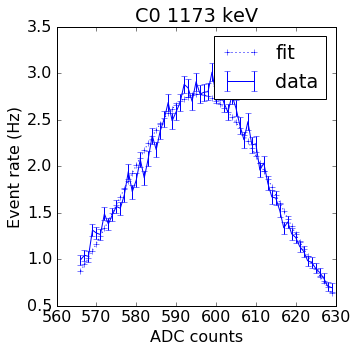

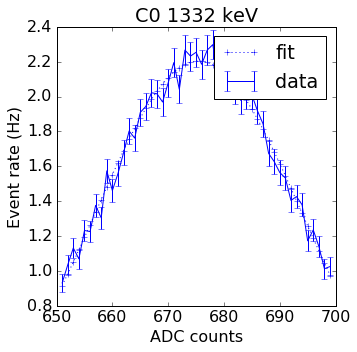

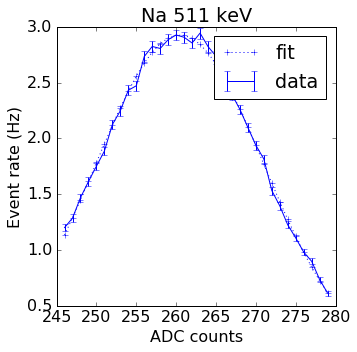

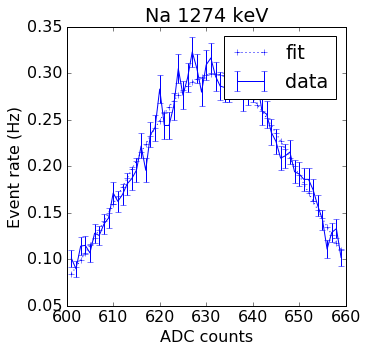

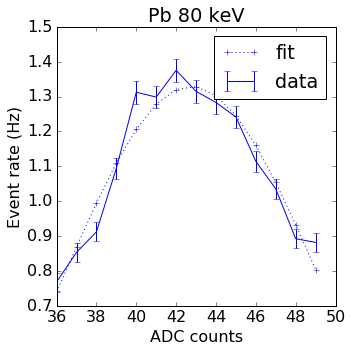

In [51]:
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import asarray as ar,exp

import math
def gaus(x,a,x0,sigma):
    if sigma<0 :
        return -100000
    return a*exp(-(x-x0)**2/(2*sigma**2))

def line(x, a, b):
    return a+b*x

def get_peaks_resolution(data, start, end, title, energy):
# print(data)
    selected = data.loc[data['channel']>start]
    selected = selected.loc[selected['channel']<end]
    x = selected.channel
    y = selected.N
    y_err = selected.NEr
    popt,pcov = curve_fit(gaus,x,y, sigma= y_err, p0=[1, (end-start)/2.+start, 20], absolute_sigma=True)
    result = {'mean': popt[1], 'mean_er':math.sqrt(pcov[1][1]),
              'sigma': popt[2], 'sigma_er':math.sqrt(pcov[2][2]), 
              "energy": energy}
              
        
    print(result)
    plt.errorbar(x,y, yerr= [val for val in  y_err], label='data')
    #plt.plot(x,y, 'ro:',label='data')
   
    plt.plot(x,gaus(x,*popt),'b+:',label='fit')
    plt.legend()
    plt.title(title)
    plt.ylabel('Event rate (Hz)')
    plt.xlabel('ADC counts')
    return result
  
res = []

fig1 = plt.figure(figsize = (5.0, 5.0))
res.append(get_peaks_resolution(df_cs,320, 400, "Cs 661 keV", 661))
fig2 = plt.figure(figsize = (5.0, 5.0))
res.append(get_peaks_resolution(df_co,565, 630, "C0 1173 keV", 1173))
fig3 = plt.figure(figsize = (5.0, 5.0))

res.append(get_peaks_resolution(df_co,650, 700, "C0 1332 keV", 1332))
fig4 = plt.figure(figsize = (5.0, 5.0))

res.append(get_peaks_resolution(df_na,245, 280, "Na 511 keV", 511))
fig5 = plt.figure(figsize = (5.0, 5.0))

res.append(get_peaks_resolution(df_na,600, 660, "Na 1274 keV", 1274))
fig5 = plt.figure(figsize = (5.0, 5.0))
res.append(get_peaks_resolution(df_na,35, 50, "Pb 80 keV", 80))
#res.append(get_peaks_resolution(df_ba,180, 220, "Ba 288 keV", 288))

#print(res[:]['mean'])

#plt.plot(result['mean'],result['energy'])

[ 4.48558099  0.50569836]
[[  2.15549365e+01  -2.94238254e-02]
 [ -2.94238254e-02   5.07205397e-05]]


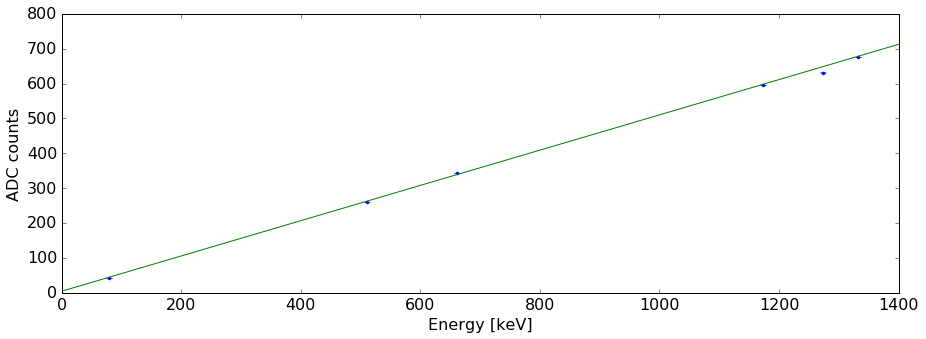

In [52]:
means = [r['mean'] for r in res]
mean_er = [r['mean_er'] for r in res]
en = [r['energy'] for r in res]

params, cov= curve_fit(line, en, means, sigma=mean_er)

plt.errorbar(en, means,yerr=mean_er, fmt='.')
x = np.linspace(0, 1400, 200)
plt.plot(x, line(x,params[0], params[1]))
plt.ylabel("ADC counts")
plt.xlabel("Energy [keV]")

print(params)
print(cov)

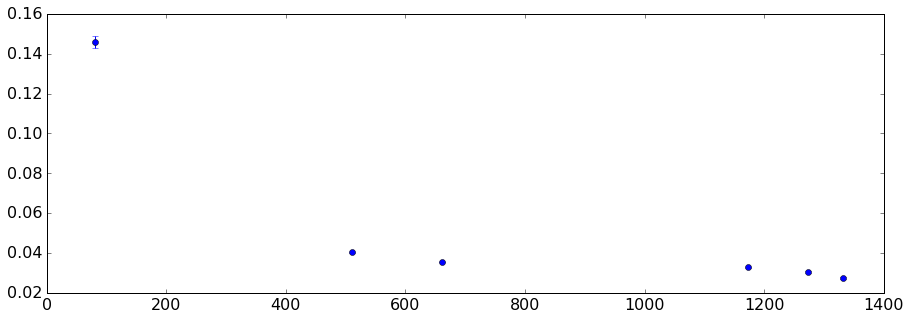

In [53]:
sigma = [r['sigma']/r['mean'] for r in res]
sigma_er = [r['sigma_er']/r['mean'] for r in res]
#en = [r['energy'] for r in res]

params, cov= curve_fit(line, en, means)
#print(params, cov)
plt.errorbar(en, sigma,yerr=sigma_er, fmt='o')
x = np.linspace(200, 1400, 200)
#plt.plot(x, line(x,params[0], params[1]))
#plt.plot(sp.linspace(200,1400), means,yerr=mean_er, fmt='o')


/data/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


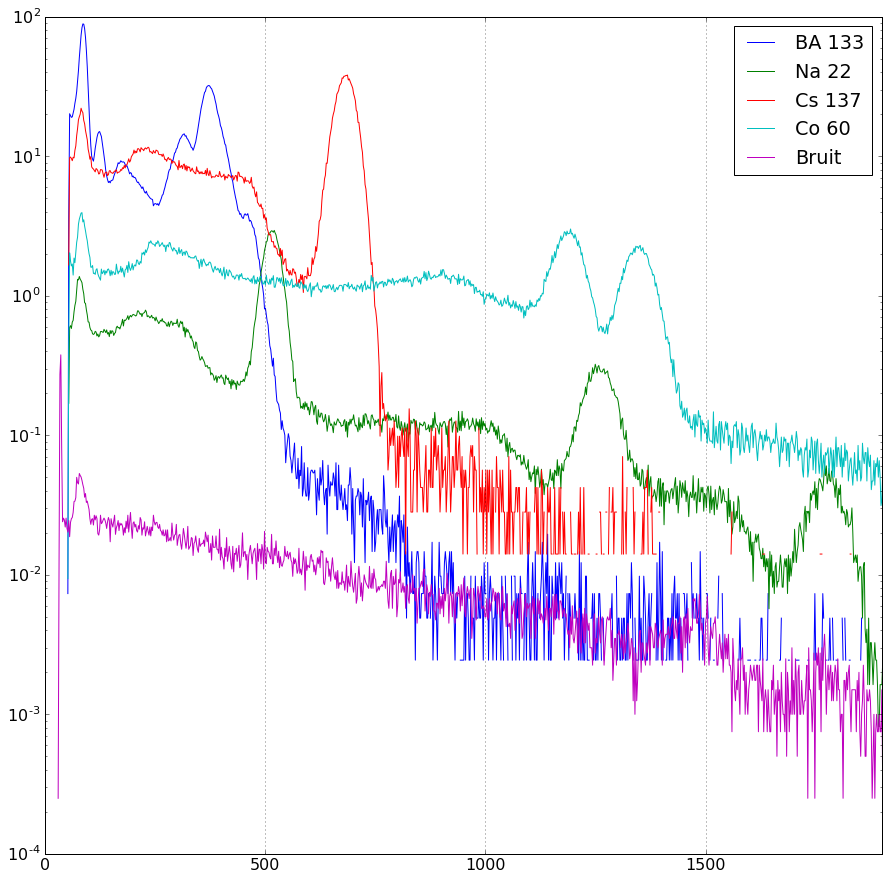

In [54]:
plt.figure(figsize = (15.0, 15.0))    # resize plots-
cal_ba = df_ba.copy()
cal_ba['channel']= cal_ba['channel']/params[1]-params[0]
plt.semilogy(cal_ba.channel, cal_ba.N, label="BA 133")
cal_na = df_na.copy()
cal_na['channel']= cal_na['channel']/params[1]-params[0]
plt.semilogy(cal_na.channel, cal_na.N, label="Na 22")
cal_cs = df_cs.copy()
cal_cs['channel']= cal_cs['channel']/params[1]-params[0]
plt.semilogy(cal_cs.channel, cal_cs.N, label="Cs 137")
cal_co = df_co.copy()
cal_co['channel']= cal_co['channel']/params[1]-params[0]
plt.semilogy(cal_co.channel, cal_co.N, label="Co 60")

cal_br = df_br.copy()
cal_br['channel']= cal_br['channel']/params[1]-params[0]
plt.semilogy(cal_br.channel, cal_br.N, label="Bruit")


plt.grid(axis="x")
plt.xlim(0, 1900)
plt.legend()

## Calibration du détecteur

## Mesure du temps du vie

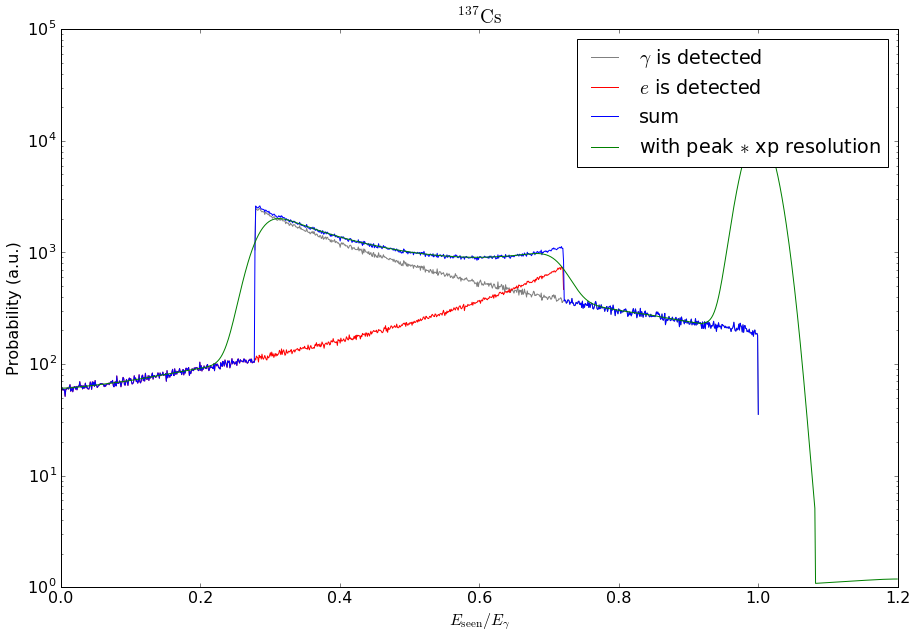

In [55]:
E = 661
bins = np.linspace(0, 1.2, 1200)
N = int(1e6)

prop = np.random.rand(N)

plt.figure(figsize = (15.0, 10.0))

costheta = 1 - 2*np.random.rand(N)
egamma = 511/(511+E*(1-costheta))
egammaCount, egammaEdges = np.histogram(egamma, bins=bins, weights=prop)
plt.semilogy(bins[:-1], egammaCount, color="gray")

costheta = 1 - 2*np.random.rand(N)
ee = 1 - 511/(511+E*(1-costheta))
eeCount, eeEdges = np.histogram(ee, bins=bins, weights=1-prop)
eeCount *= 0.3
plt.semilogy(bins[:-1], eeCount, color="red")

peak = bins.copy()[:-1]
peak[1000] = 0.6 * N

total = egammaCount + eeCount + peak

plt.semilogy(bins[:-1], total - peak)

from scipy.ndimage.filters import gaussian_filter
plt.semilogy(bins[:-1], gaussian_filter(total, sigma=20))

plt.title('${}^{137}\mathrm{Cs}$')
plt.xlabel('$E_\mathrm{seen}/E_\gamma$')
plt.ylabel('Probability (a.u.)')
plt.legend(('$\gamma$ is detected', '$e$ is detected', 'sum', 'with peak $*$ xp resolution'))